# Decision Tree

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

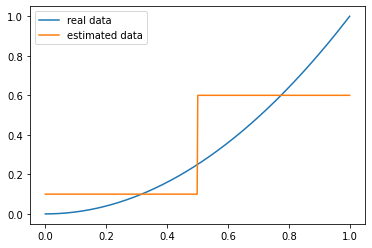

In [0]:
x = np.linspace(0.0, 1.0, 500)
y = x**2

step = [0.1 if x_ <= 0.5 else 0.6 for x_ in x]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, label = "real data")
ax.plot(x, step, label = "estimated data")

ax.legend()
plt.show()

You can find any other curves to approach the blue curve. The orange one is not a good estimation, but it is much better than using a fixed (say y = 0.5) value. A setp dunction could help us to estimate the y value in a range (in this case, 0.0~1.0) with a very simple rule.

It is the basic assumption of decision tree. How do we find some simple decision rules to model the X and y (without 'fitting' approach)?

You can even add more dimensions (rules) to solve more complicated classification problem.

Take iris problem for example...

### Titanic Problem

In [0]:
# find titanic dataset from kaggle
# you need a kaggle account
# TRY NOT to use my local copy!

# https://www.kaggle.com/c/titanic/data
# find train.csv and test.csv

train = pd.read_csv('https://drive.google.com/uc?id=1EgdUH5dMDBMj6t5ircvhgUe7gjZbCp6X')
test = pd.read_csv('https://drive.google.com/uc?id=14Xa3Bv9MRkF9Pq_JUSZFqD905j8-rsWx')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### Feature Enginerring

In [0]:
# https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset/data
# Some of the features need to be engineered.
# There's already extended work on this so we're just using
# one the best approches out there (credit to Sina, Anisotropic
# and also Megan Risdal for the suggestion of the "Title" feature).

original_train = train.copy() # just in case
full_data = [train, test]

# Define function to extract titles from passenger names
import re
def get_title(name):
  title_search = re.search(' ([A-Za-z]+)\.', name)
  # If the title exists, extract and return it.
  if title_search:
    return title_search.group(1)
  return ""

In [0]:
# feature enginerring for train and test

for dataset in full_data:
  # Feature that tells whether a passenger had a cabin on the Titanic
  dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
  
  # Create new feature FamilySize as a combination of SibSp and Parch
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
  
  # Create new feature IsAlone from FamilySize
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
  
  # Replace all NULLS in the Embarked column with 'S'
  dataset['Embarked'] = dataset['Embarked'].fillna('S')
  
  # Replace all NULLS in the Fare column with median
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
  
  # Replace all NULLS in the Age column with a random value in (avg-std, avg+std)
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
  # Next line has been improved to avoid warning
  dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)

  # Extract titles from passenger names and replace it with 
  dataset['Title'] = dataset['Name'].apply(get_title)
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

  # Mapping Sex to integer
  dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

  # Mapping titles
  title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

  # Mapping Embarked
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

  # Mapping Fare
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

  # Mapping Age
  dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age']

In [0]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,0,1,1,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,0,1,1,1


In [0]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [0]:
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


#### Feature Relation

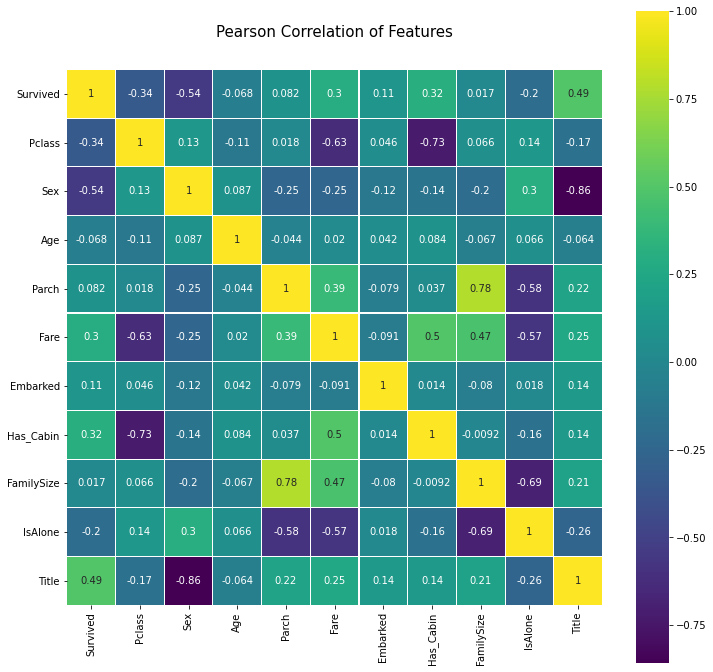

In [0]:
import seaborn as sns

plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True,
            cmap=plt.cm.viridis, linecolor='white', annot=True)

In [0]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [0]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

#### Tree

In [0]:
from sklearn import tree

In [0]:
# data
titanic_y_train = train['Survived']
titanic_x_train = train.drop(['Survived'], axis=1) 
titanic_x_test = test

# Create Decision Tree with max_depth = 3
titanic_dt = tree.DecisionTreeClassifier(max_depth = 3)
titanic_dt.fit(titanic_x_train, titanic_y_train)

# Predicting results for test dataset
titanic_y_pred = titanic_dt.predict(titanic_x_test)

Question: why max depth = 3?

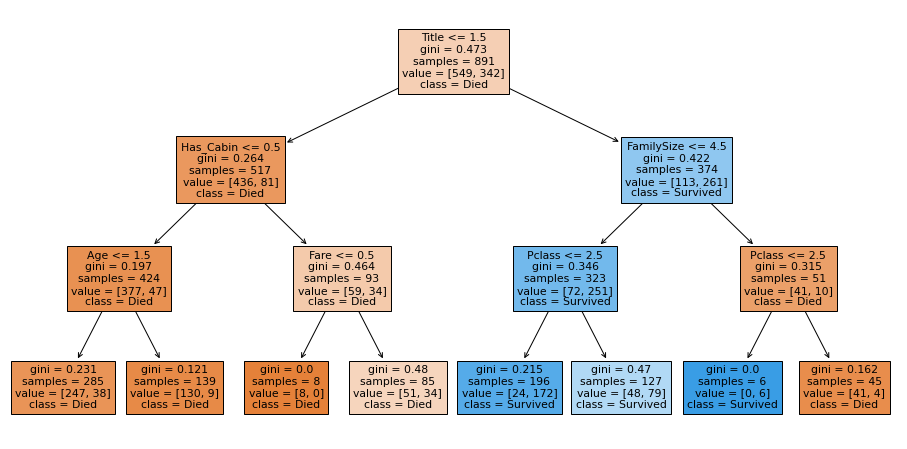

In [0]:
plt.figure(figsize = (16, 8))
tree.plot_tree(titanic_dt,
               feature_names = titanic_x_train.columns,
               class_names = ['Died', 'Survived'],
               filled = True)
plt.show()

# !!! left child node is "True", right node is "False" !!!

In [0]:
# accuracy of training data
acc_decision_tree = round(titanic_dt.score(titanic_x_train, titanic_y_train) * 100, 2)
acc_decision_tree 

82.38

### Iris Problem

In [0]:
# There are several built-in datasets. Take a look.
# https://scikit-learn.org/stable/datasets/index.html

In [0]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
iris_X, iris_y = iris.data, iris.target
dt_model = DecisionTreeClassifier()
dt_model.fit(iris_X, iris_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

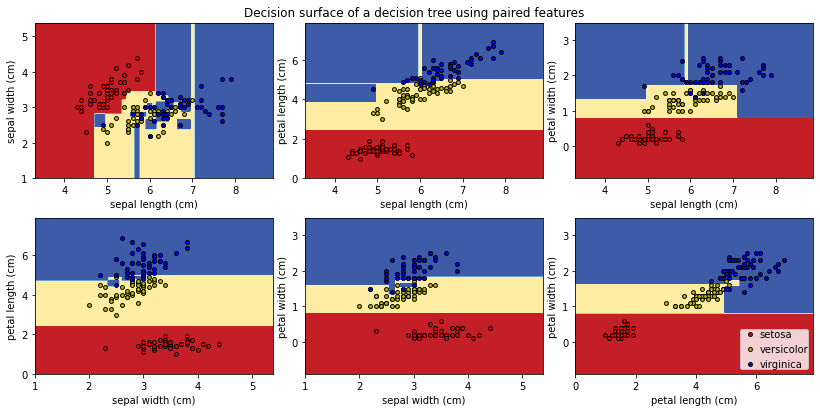

In [0]:
# using 2-d seuface to show decisions
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

fig = plt.figure(figsize = (12, 6))

# for each 2-frature pair
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris_X[:, pair]
    y = iris_y

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

plt.show()

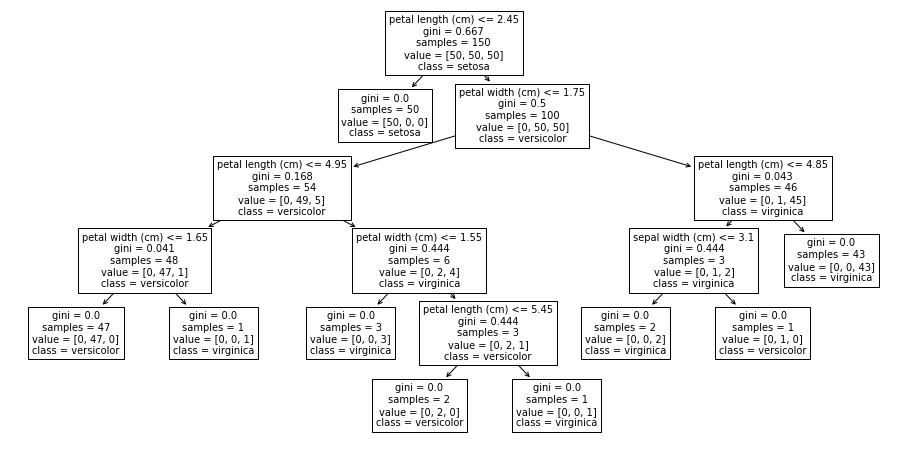

In [0]:
# using tree to show decisions
plt.figure(figsize = (16, 8))
tree.plot_tree(dt_model,
               feature_names = iris.feature_names,
               class_names = iris.target_names)
plt.show()

In [0]:
# using text to show decisions
r = tree.export_text(dt_model)
print(r)

|--- feature_2 <= 2.45
|   |--- class: 0
|--- feature_2 >  2.45
|   |--- feature_3 <= 1.75
|   |   |--- feature_2 <= 4.95
|   |   |   |--- feature_3 <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  1.65
|   |   |   |   |--- class: 2
|   |   |--- feature_2 >  4.95
|   |   |   |--- feature_3 <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- feature_3 >  1.55
|   |   |   |   |--- feature_2 <= 5.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  5.45
|   |   |   |   |   |--- class: 2
|   |--- feature_3 >  1.75
|   |   |--- feature_2 <= 4.85
|   |   |   |--- feature_1 <= 3.10
|   |   |   |   |--- class: 2
|   |   |   |--- feature_1 >  3.10
|   |   |   |   |--- class: 1
|   |   |--- feature_2 >  4.85
|   |   |   |--- class: 2



There should be several different rules to build a decision tree. How do we build the best tree?

Define "best": fewer level, higher accuracy.

Problem: the more levels it is, the more possibility the tree may overfit.

One of the resaon why decision tree is widly adopted is "explainable". People who even know nothing about machine learning can explain the tree (rules).

### The idea of Entropy

[Wiki] The information entropy, often just entropy, is a basic quantity in information theory associated to any random variable, which can be interpreted as the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes.

[Wiki] The entropy is the expected value of the self-information, a related quantity also introduced by Shannon. The self-information quantifies the level of information or surprise associated with one particular outcome or event of a random variable, whereas the entropy quantifies how "informative" or "surprising" the entire random variable is, averaged on all its possible outcomes.

---

#### Information

$X$ is a random variable.

$I(X)$ is $X$'s information that is used to measure the uncertainty of an event in $X$. If the probability of an event $x$, i.e., $P(X=x)$, is higher, then its uncertainty is lower; and the information carried in this event is fewer. 

Let $p(x)$ be $P\{X=x\}, x \in X$

$I(x) = -\log_2(p(x))$

When $p(x)=1.0$, then $I(x) = -log_2(p(x)) = 0.0$

That is, this event $x$ carries no additional information.

Question: Why is $\frac{1}{p(x)}$ the amount of information?

Hint: bit!

https://towardsdatascience.com/the-intuition-behind-shannons-entropy-e74820fe9800

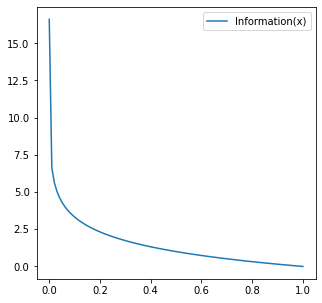

In [0]:
p = np.linspace(1e-5, 1.0-1e-5, 100)
i = -np.log2(p)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(p, i, label = "Information(x)")

ax.legend()
plt.show()

#### Entropy

Entropy is used to measure the level of information or surprise of a system. It represents the sum of the information of the entire system. The larger the value, the more uncertainty the system is.

For example, a system (random variable) has two events, 1 and 0. $P(X=1) = 0.1$ and $P(X=0) = 0.9$

Information is used to measure the uncertainty of an event; while entropy is used to measure the uncertainty of a system (i.e., all events). And we leverage the concept of "expectation" to formulate entropy $H$.

$I(X=1) = -\log_2 0.1 = 3.3219$

$H(X) = \mathbb{E}[I(X)] = \sum_x P(X=x)*I(X=x) $

$H(X) = P(X=0)*I(X=0) + P(X=1)*I(X=1) \\ = (0.9)*(-\log_2 0.9) +  (0.1)*(-\log_2 0.1) = 0.4690$




Assume we have a simple two-event ($X \in \{0,1\}$) system. The relation of the probability of $X=1$ and the system Entropy $H(X)$ looks like ...

For a two-event system with $P(X=1) = 0.5$, and it entropy is $1.0$.

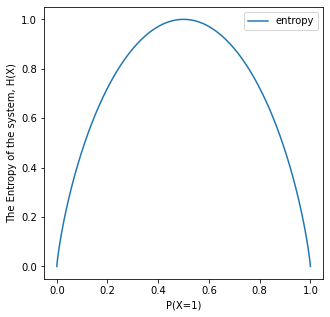

In [0]:
p = np.linspace(1e-5, 1.0-1e-5, 500) # avoid (0.0, 1.0), log error
h = -p*np.log2(p) - (1-p)*np.log2(1-p)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(p, h, label = "entropy")
ax.set_xlabel("P(X=1)")
ax.set_ylabel("The Entropy of the system, H(X)")

ax.legend()
plt.show()

Note: Usually, we use $\log_2$ in entropy related equation.

#### Conditional Entropy

$$
H(Y|X) = H(X, Y) - H(X) \\
 = [- \sum_{x,y} p(x,y) \log_2 p(x, y)] - [-\sum_{x} p(x) \log_2 p(x)] \\
 = - [\sum_{x,y} p(x,y) \log_2 p(x, y) - \sum_{x} (\sum_y p(x,y) ) \log_2 p(x)] \\
  =  - [\sum_{x,y} p(x,y) \log_2 p(x, y) - \sum_{x,y} p(x,y) \log_2 p(x)] \\
  = - \sum_{x,y} [p(x,y) ( \log_2 p(x, y) - \log_2 p(x))] \\
  = - \sum_{x,y} p(x,y) \log_2 \frac{p(x, y)}{p(x)} \\
  = - \sum_{x,y} p(x,y) \log_2 p(x| y) 
$$

#### Relative Entropy

a.k.a. Kullback-Leibler Divergence (KLD)

To measure the distance between two distributions, $P$ and $Q$.

$D_{KL}(P||Q) = \mathbb{E}_x[-\log_2 \frac{Q(x)}{P(x)}]$

$ = -\sum_{x} P(x) \log_2 \frac{Q(x)}{P(x)} = \sum_{x} P(x) \log_2 \frac{P(x)}{Q(x)} $

$ = \sum_x P(x) \log_2 P(x) - \sum_x P(x) \log_2 Q(x) $

$ = - H_p(p) + \mathbb{E}_{x \sim P}[- \log_2 Q(x)] $

$ = - H_p(p) + H_p(q)  = H_p(q) - H_p(p)$

$D_{KL}(p||q)$ means that under the 'real' distribution of P, we mesure the difference between the entropy of $Q$ and $P$. When $P = Q$, $D_{KL}(P||Q) = 0$.


#### Cross Entropy

Assume two distributions, given samples, the difinition of cross entropy is

$CEH(p, q) = \mathbb{E}_{p} [-\log_2 q] $

$ = - \sum_x p(x) \log_2 q(x)$

$ = H_p(p) = D_{KL}(P||Q) + H_{p}(p) $

If we view $H_{p}(p)$ is a constant number, minimizing $CEH(p, q)$ equals to minimizing $D_{KL}(P||Q)$. They will be both zero, when $P=Q$.

Remind: in logistic regression, let $P$ be the 'real' distribution $X \sim B(1, p)$, and $Q$ be the distribution we currently learn,  $X \sim B(1, q)$.  The cross entropy is

$CEH(p, q) = - \sum_x p(x) \log_2 q(x) $

$ = - [Prob_p(X=1) \log_2 Prob_q(X=1) + Prob_p(X=0) \log_2 Prob_q(X=0) ]$

$ = - [ p \log_2 q + (1-p) \log_2 (1-q) ]$

$ \implies - [ y \log_2 (f_\theta(x)) + (1-y) \log_2 (1-f_\theta(x)) ]$

We then calculate the average entropy for all samples.

$\frac{1}{n} \sum_{i=1}^{n} -[.]$

Hint: did you notice that the result is the same as maximum likelihood estimation?

#### Information Gain

$I(X|Y) = H(Y) - H(Y|X)$

#### Information Gain Ratio

$GR(D|A) = \frac{I(D|A)}{H_A(D)}$


### How to build a tree by impurity.

We usually use top-down approach to build a decision tree, and in each step, we choose the "best" property (i.e., feature) to split the tree.

The definition of "best" is that we can make the smaples in the child nodes as "pure" as possible. There are severl difinition of "impurity" or "purity".

* Information Gain
* Gini (impurity)
* Chi
* Variance

see https://drive.google.com/open?id=0BwIJYSzsk9qwczNsT2p2UWJ3NFU

### Pruning

To prevent overfitting, we need to cut the tree.

see https://drive.google.com/open?id=0BwIJYSzsk9qwczNsT2p2UWJ3NFU


### Discussion
Some advantages of decision trees are:

* Simple to understand and to interpret. Trees can be visualised.
* Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.
* The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
Able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable.
* Able to handle multi-output problems.
* Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
*Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
* Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.



The disadvantages of decision trees include:
* Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
* Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
* The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.
* There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.
* Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.


#### Tips
* Decision trees tend to overfit on data with a large number of features.
*Consider performing dimensionality reduction (PCA) beforehand to give your tree a better chance of finding features that are discriminative.
* Visualise your tree as you are training by using the export function. Use max_depth=3 as an initial tree depth to get a feel for how the tree is fitting to your data, and then increase the depth.
* Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant. Class balancing can be done by sampling an equal number of samples from each class, or preferably by normalizing the sum of the sample weights (sample_weight) for each class to the same value.

# Random Forest